In [1]:
import pandas as pd
import numpy as np

In [2]:
# import sys
# sys.path.append("/Users/andreasathanasopoulos/Phd/projects/bayesian_fairness/my_code/Bayesian-fairness/")

In [3]:
exp_name = "exp_compas"
exp_number = "exp_1"
base_path = "/Users/andreasathanasopoulos/Phd/projects/bayesian_fairness/"
data_path = base_path + "/my_code/Bayesian-fairness/data"
save_path = base_path + f"/my_code/Bayesian-fairness/results/{exp_name}/{exp_number}"

In [4]:
from src.utils.utils import create_directory
# create exp directory
create_directory(save_path)

# load data


In [5]:
from src.utils.data_utils import get_discrete_compas_dataset

# set atributes
Z_atr = ["sex", "race"]
X_atr = ['age_cat', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree']
Y_atr = ['two_year_recid']

# atributes to clip
clip_features = ["juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count"]
clip_value = 2

#load dataset
dataset,(n_x,n_y,n_z) = get_discrete_compas_dataset(data_path= data_path,
                                      Z_atr= Z_atr,
                                      X_atr= X_atr,
                                      Y_atr= Y_atr,
                                      clip_features = clip_features,
                                      clip_value=clip_value)

In [6]:
#split dataset into training test set
train_data = dataset.iloc[0:6000]
test_data = dataset.iloc[6000:]

In [7]:
print("training size:", train_data.shape)
print("testing size:", test_data.shape)

training size: (6000, 3)
testing size: (1214, 3)


# Algorithm

#### 1. get true model from test set

In [8]:
from src.models.dirichlet_model import DirichletModel

In [9]:
dirichlet_prior = 0.5
true_dirichlet_model = DirichletModel(n_x = n_x, n_z = n_z, n_y = n_y, prior = dirichlet_prior)
true_dirichlet_model.update_posterior_belief(data=test_data)
true_model = true_dirichlet_model.get_marginal_model()

### 2. set parameters

In [47]:
from src.utils.utility import get_eye_utility
# --- data parameters
horizon = train_data.shape[0]

num_X = n_x # number of features
num_Y = n_y # number of outcomes
num_Z = n_z # number of sensitive features
num_A = 2 # number of actions

# --- SGD parameters
n_iter = 400 # number of itteration for SGD
lr = 1.0 # learning rate

# --- Algorithm parameters
update_policy_period = 100 # period to update policy
l = 1.0 # lambda
n_samples = 16 # number of sample for bayssian policy

# --- Utility
utility = get_eye_utility(size=num_A)

### 2. initializition

In [48]:
from src.utils.policy import get_random_policy

# initialize policy
policy = get_random_policy(size = (num_A, num_X))

### 3.  run algorithm

In [49]:
tmp_save_path = save_path + f"/l_{l}"

In [50]:
from src.algorithm.marginal_fair_optimization import MarginalFairOptimization

train_belief = DirichletModel(n_x = num_X, n_y=num_Y, n_z=num_Z, prior = 0.5)

marginal_fair_algorithm = MarginalFairOptimization(true_model=true_model, policy=policy, utility=utility)

marginal_fair_algorithm.fit(train_data=train_data,
                            belief=train_belief,
                            update_policy_period=update_policy_period,
                            l=l,
                            lr=lr,
                            n_iter=n_iter)

create_directory(tmp_save_path + "/marginal")

marginal_fair_algorithm.save_results(save_path=tmp_save_path + "/marginal")

--- Step : 1 
  ------- {'fairness': 0.805, 'utility': 0.4982675575374967, 'total': -0.805}
--- Step : 101 
  ------- {'fairness': 0.3346, 'utility': 0.4939935928167899, 'total': -0.3346}
--- Step : 201 
  ------- {'fairness': 0.3576, 'utility': 0.49975642533324277, 'total': -0.3576}
--- Step : 301 
  ------- {'fairness': 0.3827, 'utility': 0.49895376870860203, 'total': -0.3827}
--- Step : 401 
  ------- {'fairness': 0.2096, 'utility': 0.49650419076714836, 'total': -0.2096}
--- Step : 501 
  ------- {'fairness': 0.2369, 'utility': 0.4932621193010748, 'total': -0.2369}
--- Step : 601 
  ------- {'fairness': 0.2327, 'utility': 0.4940873062034369, 'total': -0.2327}
--- Step : 701 
  ------- {'fairness': 0.2635, 'utility': 0.4936920143045352, 'total': -0.2635}
--- Step : 801 
  ------- {'fairness': 0.2064, 'utility': 0.49441867995156513, 'total': -0.2064}
--- Step : 901 
  ------- {'fairness': 0.1674, 'utility': 0.4957443677287646, 'total': -0.1674}
--- Step : 1001 
  ------- {'fairness': 

In [51]:
from src.algorithm.bayes_fair_optimization import BayesianFairOptimization

train_belief = DirichletModel(n_x = num_X, n_y=num_Y, n_z=num_Z, prior = 0.5)

bayessian_fair_algorithm = BayesianFairOptimization(true_model=true_model, policy=policy, utility=utility)

bayessian_fair_algorithm.fit(train_data=train_data,
                            belief=train_belief,
                            update_policy_period=update_policy_period,
                            l=l,
                            lr=lr,
                            n_iter=n_iter,
                            n_model=16)

create_directory(tmp_save_path + "/bayes")

bayessian_fair_algorithm.save_results(save_path=tmp_save_path + "/bayes")

--- Step : 1 
  ------- {'fairness': 0.2975, 'utility': 0.5089378710559197, 'total': -0.2975}
--- Step : 101 
  ------- {'fairness': 0.04, 'utility': 0.5036477950715642, 'total': -0.04}
--- Step : 201 
  ------- {'fairness': 0.0233, 'utility': 0.5024534953979509, 'total': -0.0233}
--- Step : 301 
  ------- {'fairness': 0.0178, 'utility': 0.5021948376527495, 'total': -0.0178}
--- Step : 401 
  ------- {'fairness': 0.0235, 'utility': 0.5017384393435192, 'total': -0.0235}
--- Step : 501 
  ------- {'fairness': 0.0127, 'utility': 0.501865775955066, 'total': -0.0127}
--- Step : 601 
  ------- {'fairness': 0.0124, 'utility': 0.5018798919956, 'total': -0.0124}
--- Step : 701 
  ------- {'fairness': 0.0174, 'utility': 0.5019386126698957, 'total': -0.0174}
--- Step : 801 
  ------- {'fairness': 0.0155, 'utility': 0.5015992135279619, 'total': -0.0155}
--- Step : 901 
  ------- {'fairness': 0.0157, 'utility': 0.5017768955154754, 'total': -0.0157}
--- Step : 1001 
  ------- {'fairness': 0.0115, 'u

# plots

In [57]:
tmp_save_path

'/Users/andreasathanasopoulos/Phd/projects/bayesian_fairness//my_code/Bayesian-fairness/results/exp_compas/exp_1/l_1.0'

In [58]:
import matplotlib.pyplot as plt
def comparison_plots(marginal_results, bayesian_results, atribure, title, save_path=None, show=1):
    plt.figure()
    plt.plot(marginal_results[atribure], label = "marginal")
    plt.plot(bayesian_results[atribure], label = "bayes")
    plt.title(title)
    plt.legend()
    if save_path:
        plt.savefig(save_path + f"/compare_{atribure}.png")
    if show:
        plt.show()

    plt.close()


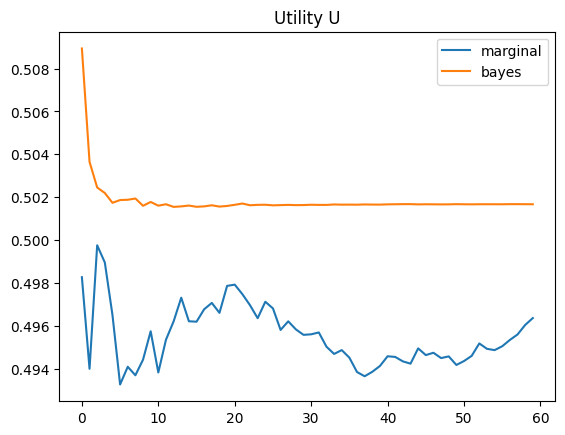

In [59]:
comparison_plots(marginal_results = marginal_fair_algorithm.results,
                 bayesian_results = bayessian_fair_algorithm.results,
                 atribure = "utility",
                 title = "Utility U",
                 save_path = tmp_save_path,
                 show = 1)

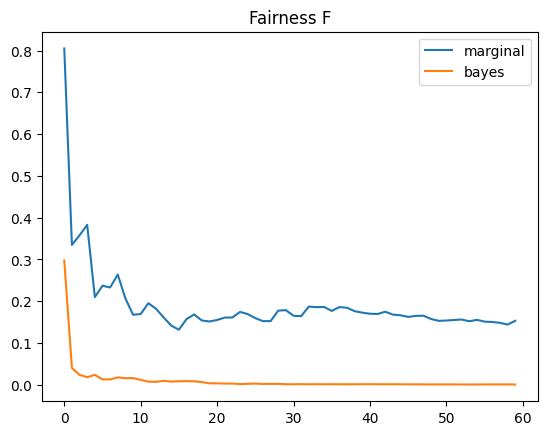

In [60]:
comparison_plots(marginal_results = marginal_fair_algorithm.results,
                 bayesian_results = bayessian_fair_algorithm.results,
                 atribure = "fairness",
                 title = "Fairness F",
                 save_path = tmp_save_path,
                 show = 1)

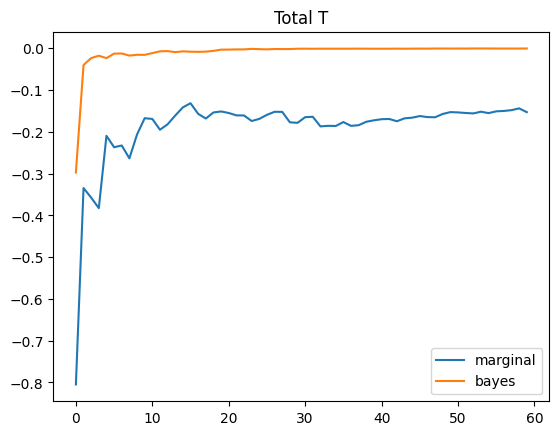

In [61]:
comparison_plots(marginal_results = marginal_fair_algorithm.results,
                 bayesian_results = bayessian_fair_algorithm.results,
                 atribure = "total",
                 title = "Total T",
                 save_path = tmp_save_path,
                 show = 1)

In [40]:
org = pd.read_csv(org_path_results + "/results.csv")

In [41]:
def fix_results(r):
    new_r = [float(sr.split(" ")[1]) for sr in r]
    return new_r

r1 = fix_results(org.iloc[9: 64 + 9 - 3]["# Created by Octave 6.2.0"].values)
r2 = fix_results(org.iloc[74: 64 + 74 - 3]["# Created by Octave 6.2.0"].values)
r3 = fix_results(org.iloc[139: 64 + 139 - 3]["# Created by Octave 6.2.0"].values)
# r4 = fix_results(org.iloc[204: 64 + 204]["# Created by Octave 6.2.0"].values)

org_pd = pd.DataFrame([r1,r2,r3]).T
org_pd.columns = ["utility","total","fairness"]

In [42]:
org_pd

,utility,total,fairness
0,0.506852,-0.190459,0.887770
1,0.518125,-0.251298,1.020722
2,0.539687,-0.395636,1.330959
3,0.551335,-0.328179,1.207693
4,0.560333,-0.326149,1.212631
...,...,...,...
56,0.581704,-0.407236,1.396176
57,0.588373,-0.514486,1.617344
58,0.584481,-0.470888,1.526257
59,0.585359,-0.450287,1.485933


<AxesSubplot: >

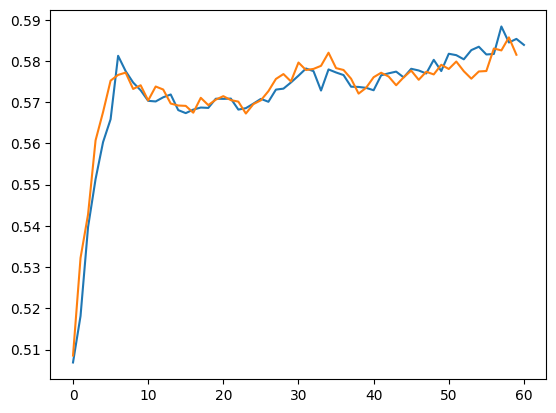

In [43]:
org_pd["utility"].plot()
pd_resutls["utility"].plot()

<AxesSubplot: >

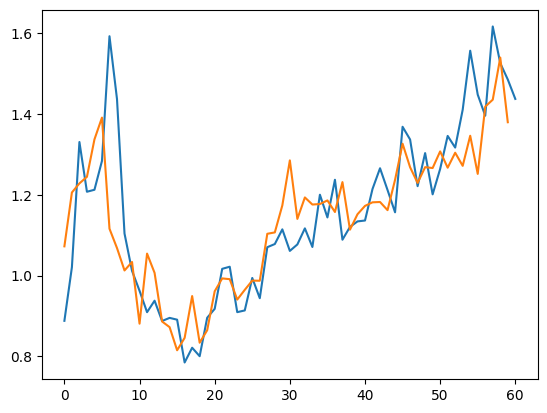

In [44]:
org_pd["fairness"].plot()
pd_resutls["fairness"].plot()

<AxesSubplot: >

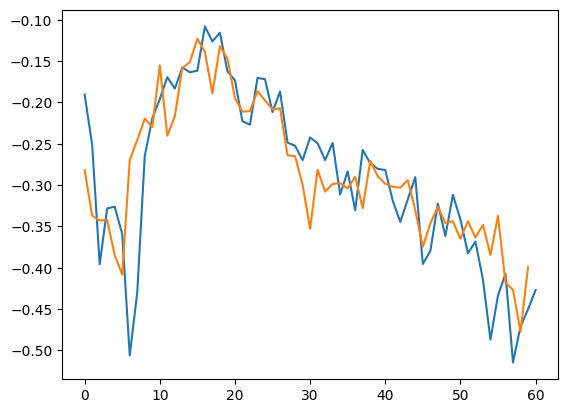

In [45]:
org_pd["total"].plot()
pd_resutls["total"].plot()

# Questions

In [ ]:
1. ProjectPolicyGradient ???